# Held \& Karp algorithm

In [2]:
using LinearAlgebra
using JuMP
using Cbc
using LightGraphs
using GraphPlot

println("Modules loaded")

Modules loaded


In [58]:
#returns the nbmin indexes for smallest values of itr
#size is the length of itr
function multiargmin(itr, nbmin, size)
    if nbmin > size
        error("multiargmin : size of array is ", size, " < nbmin = ", nbmin)
    end
    
    argmins = [i for i in 1:nbmin]
    itr_copy = deepcopy(itr)
    maxitr = maximum(itr)
    
    #we find the nbmin smallest values of itr
    for i in 1:nbmin
        argmins[i] = argmin(itr_copy)
        #once a min is found, it is set to maxitr to find a new minimum
        itr_copy[argmins[i]] = maxitr
    end
    
    return argmins
end
        

multiargmin (generic function with 1 method)

In [51]:
#connects the vertex 1 (of graph X) to the two vertices v1, v2 with smallest W1[v1], W1[v2]
#X is an adjacency matrix, W1 the weights of edges starting from 1, n the number of vertices
function connect_v1!(X, W1, n)    
    argmin1, argmin2 = multiargmin(W1[2:n], 2, n-1)
    
    X[1, argmin1+1] = 1
    X[1, argmin2+1] = 1
    
    for u ∈ 2:n
        X[u, 1] = X[1, u]
    end  
end
    

connect_v1! (generic function with 1 method)

In [106]:
function hk_mitchell(W; disp=true, maxiter=10000)
    
    # Initialization
    n = size(W, 1)
    
    if size(W, 2)!=n
        error("Weight matrice must be square")
    end
    
    λ = zeros(n)

    g = complete_graph(n-1) #in the TSP the graph is complete
    z = -1 #the objective function
    
    k = 0 
    X = falses(n, n) #the adjacency matrix of the 1-tree solutions
    
    converge = false #whether the algorithm has converged or not

    while !converge && k <= maxiter # While not a tour
        
        X = falses(n, n) #X is reset every iteration because a different 1-tree is computed
        W_updated = deepcopy(W) #we need to modify the weights according to λ
        
        # Minimum spanning tree (span_tree : st)
        for u in 2:n
            for v in 2:n
                W_updated[u,v] -= λ[u] + λ[v]
            end
        end
        st = kruskal_mst(g, W_updated[2:n,2:n])
        
        # Conversion of the spanning tree to an adjacency matrix
        for i ∈ 1:size(st, 1)
            X[src(st[i])+1, dst(st[i])+1] = 1
            X[dst(st[i])+1, src(st[i])+1] = 1
        end
        
        # We connect vertex 1 to two vertices to obtain a 1-tree
        for v in 2:n
            W_updated[1, v] -= λ[v]
        end
        connect_v1!(X, W_updated[1,:], n)
        

        #then we compute the objective value
        z = 2*sum(λ[2:n]) + sum((W[u,v] - λ[u] - λ[v])*X[u,v] for u ∈ 1:n for v ∈ 1:u)
        
        #the degrees of all vertices in graph X
        D = [sum(X[u,:]) for u ∈ 1:n]
        
        if all(D .== 2) # If not a tour, update
            converge = true
        else
            λ .= λ .+ 2 .* (2 .- D) # Experimenter d'autres règles
        end 
        
        # We display the current 1-Tree
        if disp && (k == 0 || k == maxiter || converge)
            println("Iteration", k)
            
            one_tree = SimpleGraph(X)
            edgelabel = []
            for i in 1:n
                for j in i:n
                    if X[i, j] == 1
                        push!(edgelabel, W_updated[i, j])
                    end
                end
            end
            display(gplot(one_tree, nodelabel = 1:n, edgelabel = edgelabel, edgelabelc="red"))
        end
        
        k+=1

    end
    
    return (z, X, λ)
    
end

hk_mitchell (generic function with 1 method)

In [99]:
W = [
    0   8  4 15 15  3 ;
    8   0  5 15  2 15 ;
    4   5  0  6 15 15 ;
    15 15  6  0  5  3 ;
    15  2 15  5  0  4 ;
    3  15 15  3  4  0
]

6×6 Array{Int64,2}:
  0   8   4  15  15   3
  8   0   5  15   2  15
  4   5   0   6  15  15
 15  15   6   0   5   3
 15   2  15   5   0   4
  3  15  15   3   4   0

In [107]:
z, X, λ = hk_mitchell(W)

Iteration0
Iteration2


(22.0, Bool[0 0 … 0 1; 0 0 … 1 0; … ; 0 1 … 0 0; 1 0 … 0 0], [0.0, 2.0, 0.0, 0.0, 0.0, -2.0])

In [62]:
z

22.0

In [60]:
X

6×6 BitArray{2}:
 0  0  1  0  0  1
 0  0  1  0  1  0
 1  1  0  0  0  0
 0  0  0  0  1  1
 0  1  0  1  0  0
 1  0  0  1  0  0

In [61]:
λ

6-element Array{Float64,1}:
  0.0
  2.0
  0.0
  0.0
  0.0
 -2.0

In [73]:
W = [
      0 15  0  0 15 15 15;
     15  0  1 15  0 15  1;
      0  1  0 15 15 15  1;
      0 15 15  0  1  1 15; 
     15  0 15  1  0  1 15;
     15 15 15  1  1  0  0;
     15  1  1 15 15  0  0;
]

7×7 Array{Int64,2}:
  0  15   0   0  15  15  15
 15   0   1  15   0  15   1
  0   1   0  15  15  15   1
  0  15  15   0   1   1  15
 15   0  15   1   0   1  15
 15  15  15   1   1   0   0
 15   1   1  15  15   0   0

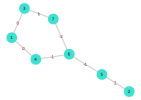

(-1.0, Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 1 0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [86]:
disp = falses(100000)
disp[1], disp[100000] = true, true
z, X, λ = hk_mitchell(W; disp=true, maxiter=100000)